# Faraday CAE

In this notebook we develop a Faraday convolutional autoencoder, and compare it to a Faraday autoencoder as well as a linear model.

## Data

We'll use the COSMOLOGY_1 POSSUM field.

In [5]:
import warnings

import astropy.io.fits, numpy, matplotlib.pyplot as plt, scipy.fftpack, astropy.units as units, astropy.wcs
import astropy.nddata
from astropy.coordinates import SkyCoord
import pandas
from tqdm import tqdm_notebook as tqdm

q_fits = astropy.io.fits.open('/run/user/697692/gvfs/sftp:host=miasma.anu.edu.au/home/alger/possum/alger/COSMOLOGY_1/image.restored.q.SB5136.contcube.3ax.fits')
u_fits = astropy.io.fits.open('/run/user/697692/gvfs/sftp:host=miasma.anu.edu.au/home/alger/possum/alger/COSMOLOGY_1/image.restored.u.SB5136.contcube.3ax.fits')

In [6]:
comps = pandas.read_csv('/run/user/697692/gvfs/sftp:host=miasma.anu.edu.au/home/alger/possum/alger/source-finding/COSMOLOGY_1_P_tbl_comp.csv')

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wcs = astropy.wcs.WCS(q_fits[0].header).dropaxis(3).dropaxis(2)

In [8]:
n_channels = q_fits[0].shape[0]
crval4 = q_fits[0].header['CRVAL4']
cdelt4 = q_fits[0].header['CDELT4']
freqs = numpy.arange(crval4, crval4 + cdelt4 * n_channels, cdelt4)[:n_channels] * units.Hz
wls = (astropy.constants.c / freqs).si ** 2

Let's grab some components. These images will have noise in them too, but less than a full image would.

In [9]:
comp_coords = SkyCoord(ra=comps._ra, dec=comps._dec, unit='deg')
test_idx = comps._peak_flux.idxmax()
test_component = comps.iloc[test_idx]
test_coord = comp_coords[test_idx]

In [87]:
# q = q_fits[0].data[:, 4000:4200, 3000:3200]
# u = u_fits[0].data[:, 4000:4200, 3000:3200]
qs = []
us = []
ps = []
wcss = []
for idx in tqdm(range(200)):
    coord = comp_coords[idx]
    q_ = astropy.nddata.Cutout2D(q_fits[0].data[0], coord, 0.5 * units.arcmin, wcs=wcs)
    bbox = (slice(0, n_channels),) + tuple([slice(*b) for b in q_.bbox_original])
    us.append(u_fits[0].data[bbox])
    qs.append(q_fits[0].data[bbox])
    ps.append(numpy.sqrt(us[-1] ** 2 + qs[-1] ** 2))
    wcss.append(q_.wcs)

/home/alg010/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/home/alg010/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in add
  del sys.path[0]


In [88]:
skip_channels = [13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 27, 94, 97, 98, 99, 100, 101]

In [89]:
for q in tqdm(qs):
    q[skip_channels] = numpy.nan
for u in tqdm(us):
    u[skip_channels] = numpy.nan

Next we'll Fourier transform Q/U along $\lambda^2$. We will do this by assuming that our observations in $\lambda^2$ are samples.

In [90]:
for p in ps:
    p[p == numpy.inf] = numpy.nan

In [91]:
percentile_90 = numpy.nanpercentile(numpy.nanmean(ps, axis=1), 90, axis=(1, 2))
p_masks = numpy.nanmean(ps, axis=1) > percentile_90[:, None, None]
print('Found', numpy.sum(p_masks), 'pixels')
pixels = [q[:, m] + 1j * u[:, m] for q, u, m in zip(qs, us, p_masks)]
pixels = numpy.concatenate(pixels, axis=1)
pixels.shape

Found 1000 pixels


(102, 1000)

In [92]:
# Mainly based on RM-tools
n_samples = 10  # across RMSF
# Faraday depth range
d_freq = numpy.nanmin(numpy.abs(numpy.diff(freqs)))
wls_range = wls.max() - wls.min()
d_wls_min = numpy.min(numpy.abs(numpy.diff(wls)))
d_wls_max = numpy.max(numpy.abs(numpy.diff(wls)))
# Set the Faraday depth range
fwhm_rmsf = 2 * numpy.sqrt(3) / wls_range * units.rad
d_phi = fwhm_rmsf / n_samples
phi_max = max(600 / units.m ** 2, numpy.sqrt(3) / d_wls_max) * units.rad
# Faraday depth sampling. Zero always centred on middle channel
n_channels_rm = round(abs((phi_max - 0) / d_phi).value) * 2 + 1
start_phi = -(n_channels_rm - 1) * d_phi / 2
stop_phi =  +(n_channels_rm - 1) * d_phi / 2
# Make a phi sample array
phi_array = numpy.linspace(start_phi, stop_phi, n_channels_rm)
data_mask = numpy.isnan(pixels)
weights = data_mask != 1
p_cube = weights * pixels
# Initialise the complex Faraday Dispersion Function (FDF) cube
n_px = pixels.shape[1]
n_phi = phi_array.shape[0]
fdf_cube = numpy.zeros((n_px, n_phi), dtype=complex)
# Get the weighted mean of the LambdaSq distribution (B&dB Eqn. 32)
K = 1 / numpy.nansum(weights)
wls_0 = K * numpy.nansum(weights * wls[:, None])
a = (-2 * 1j * phi_array)
b = (wls - wls_0) 
arg = numpy.exp(numpy.outer(a, b))
n_pixels = n_px
for k in (range(n_px)):
    fdf_cube[k, :] = K * numpy.nansum(p_cube[:, k] * arg, axis=1)

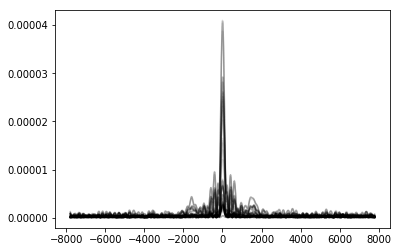

In [93]:
plt.plot(phi_array, abs(fdf_cube[:100]).T, c='k', alpha=0.1);

In [94]:
qs = numpy.array(qs)
us = numpy.array(us)
ps = numpy.array(ps)

We now have some Faraday spectra. Let's build a simple autoencoder for this data.

In [95]:
fdf_cube.shape

(1000, 869)

In [105]:
from ae import AE, torchify, numpify
import torch
from torch import nn

In [161]:
torch_fdf_cube = torchify(abs(fdf_cube[:, None, :]))
torch_fdf_cube = torch_fdf_cube / torch_fdf_cube.max()

In [210]:
def mmd_loss(x, y, alpha=1):
    B = x.size(0)
    x = x.view(x.size(0), x.size(1) * x.size(2))
    y = y.view(y.size(0), y.size(1) * y.size(2))

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

base_criterion = nn.MSELoss()

def loss_fn(pred_x, test_x, mmd_alpha=0.5, mmd_weighting=0.1):
    bc = base_criterion(pred_x, test_x)
    mmd = mmd_loss(pred_x, test_x, alpha=mmd_alpha)
    return (1 - mmd_weighting) * bc + mmd_weighting * mmd, (1 - mmd_weighting) * bc, mmd_weighting * mmd

In [205]:
def train(model, optimiser, losses=None, bc_losses=None, mmd_losses=None, loss_fn=loss_fn, n_epochs=500, do_plot=True):
    if not losses:
        losses = []
    if not bc_losses:
        bc_losses = []
    if not mmd_losses:
        mmd_losses = []
    assert len(losses) == len(bc_losses) == len(mmd_losses)

    if do_plot:
        fig = plt.figure(figsize=(6, 4))
        plot_loss, = plt.plot(losses, label='total')
        plot_bc, = plt.plot(bc_losses, label='mse')
        plot_mmd, = plt.plot(mmd_losses, label='mmd')
        plt.gca().set_yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')

    shuffle = numpy.arange(len(torch_fdf_cube))
    bar = tqdm(total=n_epochs)
    for epoch in range(n_epochs):
        model.train()
        numpy.random.shuffle(shuffle)
        optimiser.zero_grad()
        recon = model.forward(torch_fdf_cube[shuffle])
        loss, bc_loss, mmd_loss = loss_fn(recon, torch_fdf_cube[shuffle])
        loss.backward()
        loss_data = loss.item()
        losses.append(loss_data)
        bc_losses.append(bc_loss)
        mmd_losses.append(mmd_loss)
        optimiser.step()
        bar.update()
        bar.postfix = ' {:.6f}'.format(loss_data)
        if do_plot:
            plot_loss.set_data(range(len(losses)), numpy.array(losses))
            plot_bc.set_data(range(len(losses)), numpy.array(bc_losses))
            plot_mmd.set_data(range(len(losses)), numpy.array(mmd_losses))
            fig.gca().relim()
            fig.gca().autoscale_view()
            fig.canvas.draw()

In [260]:
model = AE(fdf_cube.shape[1], 250, 25).double().cuda()

In [261]:
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [262]:
losses, bc_losses, mmd_losses = [], [], []

<IPython.core.display.Javascript object>


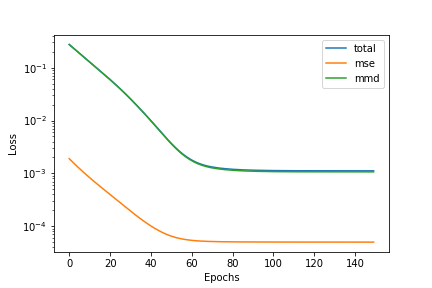

<IPython.core.display.Javascript object>


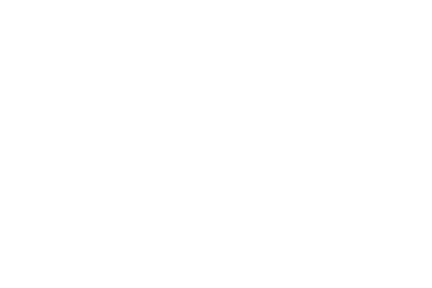

In [263]:
%matplotlib notebook
loss_fn_ = lambda *args: loss_fn(*args, mmd_alpha=0.1, mmd_weighting=0.5)
train(model, optimiser, losses, bc_losses, mmd_losses, loss_fn=loss_fn_, n_epochs=150)

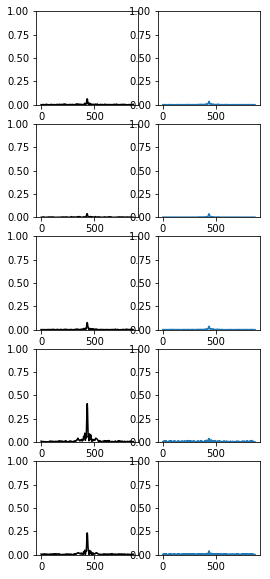

In [264]:
%matplotlib inline
plt.figure(figsize=(4, 10))
recon = model(torch_fdf_cube)
for i in range(5):
    plt.subplot(5, 2, i * 2 + 1)
    plt.plot(numpify(torch_fdf_cube[i * 10, 0]), color='k')
    plt.ylim(0, 1)
    plt.subplot(5, 2, i * 2 + 2)
    plt.plot(numpify(recon[i * 10, 0]))
    plt.ylim(0, 1)

Now let's try a CAE.

In [322]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Unflatten(nn.Module):
    def __init__(self, channels, dims):
        super().__init__()
        self.channels = channels
        self.dims = dims
    def forward(self, input):
        return input.view(input.size(0), self.channels, self.dims)

class CAE(nn.Module):
    def __init__(self, input_size, hidden_size, repr_size):
        super().__init__()
        self.input_size = self.n = input_size
        self.repr_size = self.k = repr_size
        self.hidden_size = self.h = hidden_size
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, self.h, 5, padding=2),
            nn.Tanh(),
            nn.Conv1d(self.h, self.h, 5, padding=2),
            nn.Tanh(),
            Flatten(),
            nn.Linear(self.h * self.n, self.k),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.k, self.h * self.n),
            Unflatten(self.h, self.n),
            nn.Tanh(),
            nn.ConvTranspose1d(self.h, self.h, 5, padding=2),
            nn.Tanh(),
            nn.ConvTranspose1d(self.h, 1, 5, padding=2),
        )
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)
        # Decode
        x = self.decoder(x)
        return x

In [323]:
model_cae = CAE(fdf_cube.shape[1], 10, 25).double()

In [324]:
model_cae.forward(torch_fdf_cube[:100].cpu()).shape

torch.Size([100, 1, 869])